In [11]:
import os
import pandas as pd
import numpy as np
import rasterio as rio
from itertools import product
from rasterio import windows
import matplotlib.pyplot as plt

from osgeo import gdal
from osgeo.gdalconst import GDT_Int16

In [19]:
def NDVI(red: pd.Series, nir: pd.Series):
    ndvi = (nir - red) / ((nir + red).apply(lambda x: 0.000001 if x == 0 else x))
    return ndvi

def EVI(red: pd.Series, nir: pd.Series):
    evi2 = (
        2.5
        * (nir - red)
        / ((nir + 2.4 * red + 1).apply(lambda x: 0.000001 if x == 0 else x))
    )
    return evi2

def NDRE(red_far: pd.Series, nir: pd.Series):
    ndre = (nir - red_far) / (
        (nir + red_far).apply(lambda x: 0.000001 if x == 0 else x)
    )
    return ndre

def MSAVI(red: pd.Series, nir: pd.Series):
    msavi = (2 * nir + 1 - ((2 * nir + 1) ** 2 - 8 * (nir - red)) ** (1 / 2)) / 2
    return msavi


def normalize_pixel(X: np.ndarray) -> np.ndarray:
        X = X / 10000
        X = np.clip(X, 0, 0.3)
        return X
    
        
def get_SVI(df: pd.DataFrame) -> pd.DataFrame:
    nir = df.loc[:, "B08"]
    red = df.loc[:, "B04"]
    red_far = df.loc[:, "B05"]
    df.loc[:, "NDVI"] = NDVI(red=red, nir=nir)
    df.loc[:, "NDRE"] = NDRE(red_far=red_far, nir=nir)
    df.loc[:, "MSAVI"] = MSAVI(red=red, nir=nir)
    df.loc[:, "EVI"] = EVI(red=red, nir=nir)
    return df


def get_tiles(ds, width=256, height=256):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

def get_dataset(x: np.ndarray)->pd.DataFrame:
    
    bands = x[:13, ...]
    bands = to_2d_array(x[:13, ...])    
    df = pd.DataFrame(bands.T, columns=col_names)
    df[col_names] = normalize_pixel(df.values)
    df = get_SVI(df)
    terrain = to_2d_array(x[-4:, ...])
    df_terrain = pd.DataFrame(terrain.T, columns=["aspect", "slope", 
                                                      "wetnessindex", "sink"])
    return pd.concat([df,df_terrain], axis=1)

def to_2d_array(x: np.ndarray)->np.ndarray:
    return x.reshape(x.shape[0], x.shape[1] * x.shape[2])

def save_tif(raster_input:str, raster_output:str, values:np.array):
    in_data, out_data = None, None
    in_data = gdal.Open(raster_input)
    if in_data is None:
        print ('Unable to open %s' % raster_input)
    band1 = in_data.GetRasterBand(1)
    rows = in_data.RasterYSize
    cols = in_data.RasterXSize
    driver = in_data.GetDriver()
    out_data = driver.Create(raster_output, cols, rows, 1, GDT_Int16)
    dem_data = np.array(values)
    out_band = out_data.GetRasterBand(1)
    out_band.WriteArray(dem_data)
    out_band.FlushCache()
    out_band.SetNoDataValue(-1)

    out_data.SetGeoTransform(in_data.GetGeoTransform())
    out_data.SetProjection(in_data.GetProjection())
    del out_data
    return 'Done'

In [20]:

col_names = ["B01","B02","B03","B04",
            "B05","B06","B07","B08",
            "B8A","B09","B10","B11","B12"]

fname = '../rasters/bands_and_terrain.tiff'

In [21]:
def simple_classifier(df: pd.DataFrame)->np.ndarray:
    # Здесь надо добавить свой классификатор, для примера, простой классифатор по NDVI
    
    # df - датафрейм со столбцами - ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
    #        'B10', 'B11', 'B12', 'NDVI', 'NDRE', 'MSAVI', 'EVI', 'aspect', 'slope',
    #        'wetnessindex', 'sink']
    # на выход надо вернуть вектор размер df.shape[0]
    mask = df['NDVI']>0.6
    return (mask*1).values


In [22]:

# Задаем размер кусочков (тайлов), которые будем классифицировать
tile_width, tile_height = 512, 512

with rio.open(fname, 'r+') as src:
    meta = src.meta.copy()
    output_mask = np.zeros(shape = (meta['height'], meta['width']))
    # Здесь можно добавить tqdm для отслеживания процесса
    for window, transform in get_tiles(src, 
                                       width=tile_width,
                                       height=tile_height):
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
        
        x = src.read(window=window)
        df = get_dataset(x)
        
        predictions = simple_classifier(df)
        forest_tile = predictions.reshape(meta['height'], meta['width'])
        ranges = window.toranges()
        output_mask[ranges[0][0]:ranges[0][1],ranges[1][0]:ranges[1][1]] = forest_tile

raster_output = '../rasters/prediction.tif'
status = save_tif(raster_input=fname, raster_output=raster_output, values=output_mask)
print(status)

Done


In [23]:
with rio.open(raster_output, 'r+') as src:
    forest = src.read()

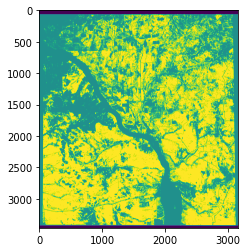

In [24]:
plt.imshow(forest[0])

End